### Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Library

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers
!pip install scikit-learn
!pip install seaborn
!pip install torch

In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git  # "git clone" digunakan untuk mengunduh code yang ada pada repository.

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312
Receiving objects: 100% (460/460), 4.83 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [ ]:
# DataFrame


# NLP
import nltk
nltk.download('punkt')

# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
#import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Dataset

In [ ]:
# 2. Exploratory Data Analysis
stopword_path = '/content/drive/MyDrive/sentimen-bert-try/stopword.txt'
kamus_alay_path = '/content/drive/MyDrive/sentimen-bert-try/kamus_alay.csv'

In [ ]:
# Import data

df = pd.read_excel('/content/drive/MyDrive/sentimen-bert-try/train-dataset.xlsx')

# Definisikan pemetaan label
pemetaan_label = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}

# Ubah label dalam dataset menggunakan pemetaan_label
df['label'] = df['label'].map(pemetaan_label)

# Simpan kembali dataset yang telah diubah ke file Excel
df.to_excel('train_dataset_new.xlsx', index=False)

In [ ]:
df.sample(5)
print(f'shape: {df.shape}')

shape: (774, 2)


In [ ]:
## Proporsi Variabel Target
df['label'].value_counts()

label
negative    329
neutral     305
positive    140
Name: count, dtype: int64

In [ ]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = df.label.value_counts()
labels = ['Negatif', 'Netral', 'Positif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

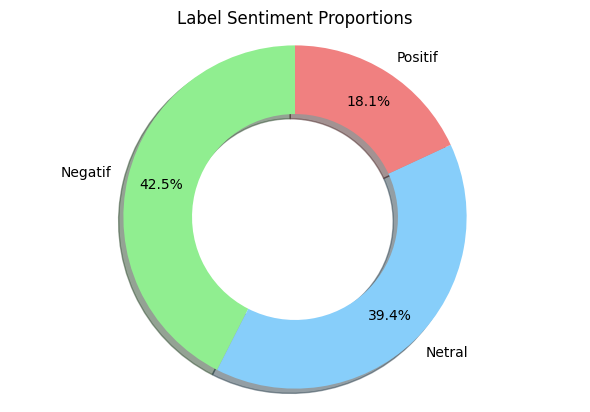

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Label Sentiment Proportions')

plt.show()

In [ ]:
# 3. PreProcessing
## Preprocessing Tahap 1
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [ ]:
def clean_text(text):
  # ubah text menjadi huruf kecil
  text = text.lower()

  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

In [ ]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(clean_text)

  # delete empty row
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp

In [ ]:
df_v1 = preprocess_v1(df)
# export to tsv
# df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)
## Preprocessing Tahap 2
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, sep='/n', names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

<ipython-input-20-e2e8cd24ca6b>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  default_stop = pd.read_csv(stopword_path, sep='/n', names=['stopwords'])


In [ ]:
def normalize_text(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()i
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [ ]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(normalize_text)

  # delete empty row
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp
# take a while
df_v2  = preprocess_v2(df_v1)
df_v2

,text,label
0,meteran berputar tapi angka tidak jalan,negative
1,petugas pdam tidak melakukan tugas cek meteran...,negative
2,"tagihan bulan . jan. m , shrsnya m",negative
3,pipa bocor di enggak depan rumah kalo malam de...,negative
4,pemakaian tidak sesui.tagihan mohon di cek lap...,negative
...,...,...
769,"terkait pemasangan baru , sekitar rumah belum ...",neutral
770,air masih sudah mulai keluar tapi belum normal...,neutral
771,min antri proses survey untuk pemasangan baru ...,neutral
772,halo kak . saya mendaftar pemasangan baru dan ...,neutral


In [ ]:
pip install datasets

In [ ]:
# Assuming 'label' column contains string labels like 'positive', 'negative', 'neutral'
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
df_v2['label'] = df_v2['label'].map(label_mapping)

In [ ]:
pip install Dataset

In [ ]:
# Create or update the dataset
from datasets import Dataset
dataset = Dataset.from_pandas(df_v2)
dataset = dataset.train_test_split(test_size=0.3)

In [ ]:
dataset["train"][0]

{'text': 'apresiasi dan terima kasih kepada pdam yang telah berbagi dengan masyarakat dan anak yang kurang mampu untuk meringankan beban hidupnya',
 'label': 0}

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Get the maximum sequence length in your dataset
max_seq_length = max(len(tokenizer(text)["input_ids"]) for text in dataset["train"]["text"])

# Tokenize function
def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt", max_length=max_seq_length)
    return {"input_ids": tokenized_inputs["input_ids"], "attention_mask": tokenized_inputs["attention_mask"], "label": examples["label"]}

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/233 [00:00<?, ? examples/s]

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
# from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# model = BertForSequenceClassification.from_pretrained("ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa")

In [ ]:
pip install wandb

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: lrapunzie. Use `wandb login --relogin` to force relogin


True

In [ ]:
pip install accelerate -U

In [ ]:
from transformers import Trainer

In [ ]:
from transformers import TrainingArguments

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments

# Define the number of folds
num_folds = 2
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=max_seq_length,
    )
    return {
        "input_ids": tokenized_inputs["input_ids"],
        "attention_mask": tokenized_inputs["attention_mask"],
        "label": examples["label"],
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir="sentiment_analisis_indonlu",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=50,
    weight_decay=0.01,
)

# Initialize lists to store evaluation results
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Iterate over the folds
for fold, (train_idx, val_idx) in enumerate(skf.split(df_v2['text'], df_v2['label'])):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets for this fold
    train_data = df_v2.iloc[train_idx]
    val_data = df_v2.iloc[val_idx]

    # Preprocess and tokenize the data for this fold
    train_dataset = Dataset.from_pandas(preprocess_v2(train_data))
    val_dataset = Dataset.from_pandas(preprocess_v2(val_data))

    tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
    tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = BertForSequenceClassification.from_pretrained("ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa").to(device)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer.train()

    # Evaluate the model on the validation set for this fold
    results = trainer.predict(tokenized_val_dataset)

    # Extract predictions and labels
    predictions = results.predictions.argmax(axis=1)
    labels = tokenized_val_dataset["label"]

    # Calculate metrics for this fold
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    # Append results to lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Calculate and print average metrics across all folds
avg_accuracy = sum(accuracies) / num_folds
avg_precision = sum(precisions) / num_folds
avg_recall = sum(recalls) / num_folds
avg_f1 = sum(f1_scores) / num_folds

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")

Fold 1/2


Map:   0%|          | 0/387 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,No log,0.357031
2,No log,0.252383
3,No log,0.244016
4,No log,0.264684
5,No log,0.260629
6,No log,0.277130
7,No log,0.289460
8,No log,0.318443
9,No log,0.328697
10,No log,0.321800


Fold 2/2


Map:   0%|          | 0/387 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.421863
2,No log,0.252281
3,No log,0.231219
4,No log,0.231528
5,No log,0.237001
6,No log,0.252439
7,No log,0.258003
8,No log,0.263491
9,No log,0.281862
10,No log,0.291243


Average Accuracy: 0.9470
Average Precision: 0.9471
Average Recall: 0.9470
Average F1-score: 0.9469


In [ ]:
print(tokenized_train_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 387
})


In [ ]:
training_args = TrainingArguments(
    output_dir="sentiment_analisis_indonlu",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=12,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.194824
2,No log,0.171093
3,No log,0.163378
4,No log,0.206336
5,No log,0.189569
6,No log,0.186662
7,No log,0.188174
8,No log,0.182951
9,No log,0.181449
10,No log,0.182832


TrainOutput(global_step=204, training_loss=0.018556753794352215, metrics={'train_runtime': 136.8435, 'train_samples_per_second': 47.441, 'train_steps_per_second': 1.491, 'total_flos': 363645354609432.0, 'train_loss': 0.018556753794352215, 'epoch': 12.0})

In [ ]:
trainer.save_model('./sentiment_analisis_indonlu')

In [ ]:
comment_text = "sudah ngadu via customer service tapi sampai sekarang ga dikerjakan"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/sentiment_analisis_indonlu")
comment(comment_text)

[{'label': 'Negative', 'score': 0.9942136406898499}]

In [ ]:
comment_text = "habis lapor air keluar pelan cenderung MATI, tapi setelah di survey dan penjelasan. 2-3 hari air JOSS seperti pake pompa air 👏👏👏 terimakasih atas pelayanan nya"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/sentiment_analisis_indonlu")
comment(comment_text)

[{'label': 'Negative', 'score': 0.9946744441986084}]

In [ ]:
comment_text = "Meter sya mati (ngak jalan) sdh lapor cuma dilihat saja tindak lanjutnya belum tampakJl. Kalisari Gg 3/1 surabaya"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/sentiment_analisis_indonlu")
comment(comment_text)

[{'label': 'Negative', 'score': 0.9999200105667114}]

In [ ]:
comment_text = "Air di rumah keruh/kotor sudah 3 hari ini ngadu tp tdk ada penanganan sama sekali kenapa lambat banget ya?😃"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/sentiment_analisis_indonlu")
comment(comment_text)

[{'label': 'Negative', 'score': 0.9980643391609192}]

In [ ]:
comment_text = "kapan ya diperbaiki?"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/sentiment_analisis_indonlu")
comment(comment_text)

[{'label': 'Neutral', 'score': 0.999911904335022}]

In [ ]:
comment_text = "hihihi makasi yaa pdam airnya uda nyala loveu"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/drive/MyDrive/sentimen-bert-try/sentiment-v3")
comment(comment_text)

[{'label': 'Positive', 'score': 0.968930721282959}]

In [ ]:
comment_text = "mati yg ga wajar.. air keluar ga keluar ga,, skrg malah ga keluar .. kmren siang sampek jam 11 malam mati, keluar trs shubuh mati lagi sampek skrg????? .. kali ini bnr2 parah"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/drive/MyDrive/sentimen-bert-try/sentiment-v3")
comment(comment_text)

[{'label': 'Negative', 'score': 0.9996960163116455}]

In [ ]:
comment_text = "Kulihat2 komen paling komplain air mati doang , jarang banget komplain air bau / keruh , apa cuma daerahku doang ya 🤢 Bener2 parah banget bau sama keruhnya , boro2 dipakai masak , dipakai mandi aja mikir2"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/drive/MyDrive/sentimen-bert-try/sentiment-v3")
comment(comment_text)

[{'label': 'Negative', 'score': 0.9991686344146729}]

In [ ]:
comment_text = "banyu nang daerah mulyorejo tengah sampek saiki wangel dan sering ga murup, wayahe kerjo sregep langsung diupload, wayahe sing gak ngatasi mbidek. alasan grgr pekerjaan box culvert, kudune sesama pekerja pemkot iku bersinergi yaopo carane ben iso tuntas, gak malah salah2an antar bidang pekerjaan, sesekali kudu kerjo melok cino ancen ben duwe standart dan integeritas tinggi ! yaopo ndan iki @cakj1"

from transformers import pipeline

comment = pipeline("sentiment-analysis", model="/content/drive/MyDrive/sentimen-bert-try/sentiment-v3")
comment(comment_text)

[{'label': 'Positive', 'score': 0.9994801878929138}]

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluate the model
results = trainer.predict(tokenized_dataset["test"])

# Extract predictions and labels
predictions = results.predictions.argmax(axis=1)
labels = tokenized_dataset["test"]["label"]

# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9700
Precision: 0.9701
Recall: 0.9700
F1-score: 0.9699


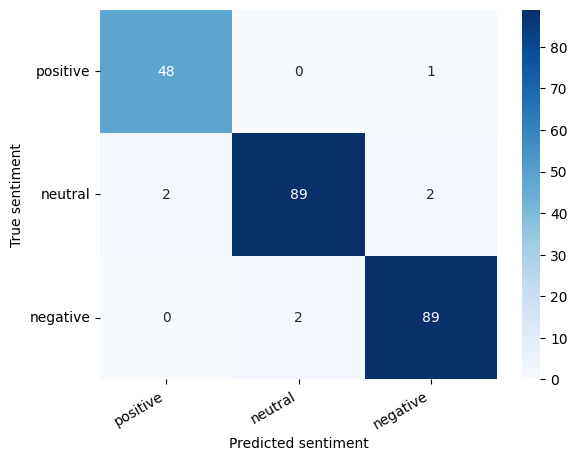

In [ ]:
 from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(labels, predictions)

# Create a DataFrame for better visualization
class_names = ['positive', 'neutral', 'negative']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# Function to display confusion matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

# Display confusion matrix
show_confusion_matrix(df_cm)
plt.show()
